In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import os

def data_loader(path,months,days,year,_str_features,prefix,suffix,red_feature=True):
    """ This function reads yield data from the detection results files for every date and arranges data into X and y
    Args:
        path (string): string containing path to folder where detection results are located
        months (string list): list with strings of the months in the dates of every file for detection results
        days (string list): list with strings of the days in the dates of every file for detection results
        year (string): string of year in the dates of every file for detection results
    Returns:
        np.array, np.array: X and y data 
    """
    df_list = []
    for i in range(len(months)):
        join_date = '-'.join([months[i], days[i], year])
        if prefix == '':
            df_list.append(pd.read_csv(path + join_date + suffix))
        else:
            df_list.append(pd.read_csv(path + prefix + join_date + suffix))

    time_spacing = time_gaps(months, days, year) # Get time gaps (in days) between dates
    if red_feature:
        n_features = len(_str_features)
    else:
        n_features = len(_str_features) - 1 # red class is removed from features as this is the target variable
    num_rows = len(df_list[0])
    num_cols = len(df_list)
    y_data = np.zeros((len(df_list[0]), num_cols)) # Array to contain y data
    X_data = np.zeros((len(df_list[0]), n_features * num_cols)) # Array to contain X data
    X_col_idx = 0 # Column idx for adding data in X data 

    for df_idx,df in enumerate(df_list):
        try:
            for i_class in _str_features:
                if i_class == 'red':
                    red_count = np.array(df['red'])
                    y_data[:,df_idx] = red_count
                    if df_idx < (num_cols-1):
                        X_data[:,X_col_idx] = red_count
                        X_col_idx += 1
                elif i_class == 'gaps':
                    if df_idx < (num_cols-1):
                        gaps = time_spacing[df_idx]
                        gaps_array = np.full((num_rows,), gaps)
                        X_data[:,X_col_idx] = gaps_array # remove last column
                        X_col_idx += 1
                else:
                    class_count = np.array(df[i_class])
                    X_data[:,X_col_idx] = class_count
                    X_col_idx += 1
            y_Data = y_data[:, 1:] # Remove first column as red count in the first date is not used
            X_Data = X_data[:, :-n_features] # Remove last 6 columns as X features for last date are not used
        except KeyError:
            print(f"DataFrame: {df_list.index(df) + 1}, Column or Row not found.")
    return X_Data, y_Data

def extract_dates_from_filenames(folder_path,year):
    # List to store extracted dates
    dates = []
    # Loop through all files in the folder
    for filename in os.listdir(folder_path):
        if year==2023:
            try:
                # Extract the date substring after the second '_'
                #date_str = filename.split('_')[2].split('.')[0]
                date_str = filename.split('_')[0]
                date_obj = datetime.strptime(date_str, '%m-%d-%Y')
                dates.append(date_obj)
            except (IndexError, ValueError):
                # Skip files that do not match the expected format
                continue
        elif year==2022:
            try:
                date_str = filename.split('_')[0]
                date_obj = datetime.strptime(date_str, '%m-%d-%Y')
                dates.append(date_obj)
            except (IndexError, ValueError):
                # Skip files that do not match the expected format
                continue
    # Sort dates in chronological order
    dates.sort()
    #print(type(dates[0]))
    # Remove duplicates by converting to a set and back to a list
    unique_dates = list(set(dates))
    # Sort the dates in chronological order
    unique_dates.sort()
    # Decompose dates into months, days, and the year
    #months = [date.month for date in dates]
    #days = [date.day for date in dates]
    #year = dates[0].year if dates else None
    months = [str(date.month).zfill(2) for date in unique_dates]
    days = [str(date.day).zfill(2) for date in unique_dates]
    #f_year = str(dates[0].year if unique_dates else None)
    return months, days, str(year)

def time_gaps(months,days,year): 
    """ This functions generates the time gaps vector
    Args:
        months (string list): list with strings of months
        days (string list): list with strings of days
        year (string): string of year variable
    Returns:
        string list: list containing time gaps
    """
    year = int(year)
    # Convert strings to datetime objects
    dates = [datetime(year, int(month), int(day)) for month, day in zip(months, days)]
    # Calculate the difference in days between consecutive dates
    differences = [(dates[i+1] - dates[i]).days for i in range(len(dates)-1)]
    return differences


In [2]:
_string_var = ['flower','green', 'sw', 'lw', 'pink', 'red', 'gaps']
yield_path = '/Users/andres/Documents/yield_data/output_yolov10_avg_all/'
#yield_path = '/Users/andres/Documents/yield_data/output/2023/'
months, days, year = extract_dates_from_filenames(yield_path,year=2022)
#print(year)
#print(len(months))
#X_Data, y_Data = data_loader(yield_path, months, days, year, _string_var,'', '_x4bs.csv')
X_Data, y_Data = data_loader(yield_path, months, days, year, _string_var,'','_4.csv')

## Get min error to red(t+1) from all classes(t)

In [133]:
#X_Data[0][6] # time interval
min_errors = []
min_indices = []
time_intervals = []
for location in range(len(y_Data)):
    for time_step in range(1,16):
        counts = []
        for i in range(5):
            index = i+(time_step*7)-7
            stage_count = X_Data[location][index]
            counts.append(stage_count)
        time_interval = X_Data[location][6+(time_step*7)-7]
        #print(counts, time_interval)
        next_yield = y_Data[location][time_step-1]
        #print(next_yield)
        #
        errors = []
        for count in counts:
            error = next_yield - count
            errors.append(error)
        #print(errors)
        if time_interval > 10:
            min_error = np.min(errors[0:4])
            min_index = np.argmin(errors[0:4])
        else:
            min_error = np.min(errors[-2:])
            min_index = np.argmin(errors[-2:])
            min_index+=3
        #print(errors)
        min_errors.append(min_error)
        min_indices.append(min_index)
        time_intervals.append(time_interval)



In [125]:
#X_Data[0][6] # time interval
#min_errors = []
#min_indices = []
#time_intervals = []
init_ts = 7
for location in range(len(y_Data)):
    for time_step in range(init_ts,init_ts+1):
        counts = []
        for i in range(5):
            index = i+(time_step*7)-7
            stage_count = X_Data[location][index]
            counts.append(stage_count)
        time_interval = 0.0
        for time_count in range(1,init_ts+1):
            time_interval += X_Data[location][6+(time_count*7)-7]
            #print(time_interval)
        #print(counts, time_interval)
        final_yield = y_Data[location][time_step-1]
        #print(next_yield)
        #
        errors = []
        for count in counts:
            error = abs(next_yield - count)
            errors.append(error)
        #print(errors)
        if time_interval > 10:
            min_error = np.min(errors[0:4])
            min_index = np.argmin(errors[0:4])
        else:
            min_error = np.min(errors[-2:])
            min_index = np.argmin(errors[-2:])
            min_index+=3
        #print(errors)
        min_errors.append(min_error)
        min_indices.append(min_index)
        time_intervals.append(time_interval)

In [126]:
np.array(min_indices).max()

4

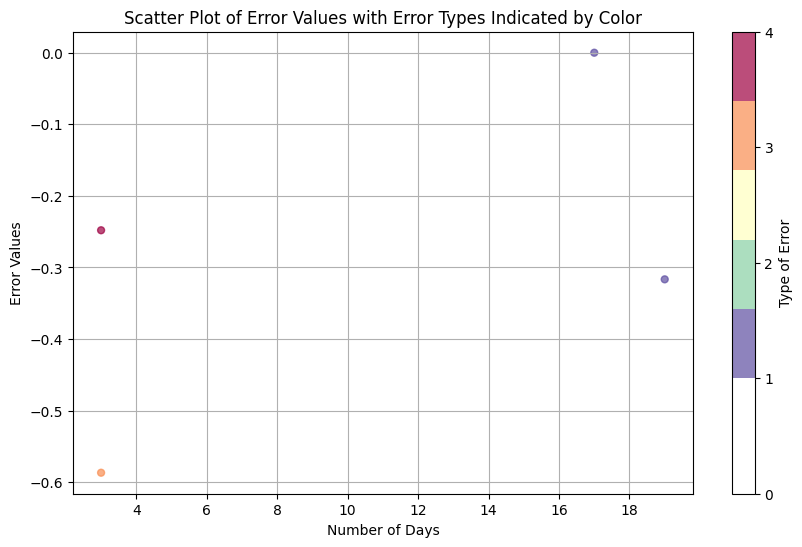

In [134]:
import matplotlib.pyplot as plt

# Sample data
error_values = min_errors
error_types = min_indices
days = time_intervals

# Define the threshold
threshold = 1

# Filter the lists based on the threshold
filtered_error_values = [ev for ev in error_values if ev <= threshold and ev >=-threshold]
filtered_error_types = [error_types[i] for i in range(len(error_values)) if error_values[i] <= threshold and error_values[i] >=-threshold]
filtered_days = [days[i] for i in range(len(error_values)) if error_values[i] <= threshold and error_values[i] >=-threshold]

# Define a colormap
cmap = plt.get_cmap("Spectral_r", 5)  # 'viridis' is just an example, you can use any colormap you like

# Create scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(filtered_days, filtered_error_values, c=filtered_error_types, s=25, cmap=cmap, alpha=0.7)

# Add colorbar to indicate error types
cbar = plt.colorbar(scatter, ticks=np.arange(5))
cbar.set_label('Type of Error')
cbar.set_ticks([0, 1, 2, 3, 4])
cbar.set_ticklabels(['0', '1', '2', '3', '4'])

# Add labels and title
plt.xlabel('Number of Days')
plt.ylabel('Error Values')
plt.title('Scatter Plot of Error Values with Error Types Indicated by Color')
plt.grid(True)

# Show plot
plt.show()

## Get min errors from all classes(t) to all classes (t+1), nested

In [156]:
print(X_Data[0][0:7])
print(X_Data[0][7:14])
print(y_Data[0][0])

[ 8.94605144 99.56530121 17.67624191  5.19698109  6.90702759 61.64394539
 11.        ]
[0.   1.45 1.   0.   0.   3.5  7.  ]
3.5


In [153]:
#X_Data[0][6] # time interval
min_errors = []
min_indices = []
time_intervals = []
for location in range(3,4):#len(y_Data[0])
    for time_step in range(1,2):
        counts = []
        errors = []
        for i in range(5):
            index = i+(time_step*7)-7
            stage_count = X_Data[location][index]
            errors1_2 = []
            for j in range(i,6):
                index_2 = j+((time_step+1)*7)-7
                stage_count_2 = X_Data[location][index_2]
                error1_2 = (stage_count_2 - stage_count) / stage_count
                errors1_2.append(error1_2)
            errors.append(errors1_2)
            #counts.append(stage_count)
        time_interval = X_Data[location][6+(time_step*7)-7]
        #print(counts, time_interval)
        #next_yield = y_Data[location][time_step-1]
class_strings = ['flower','green', 'sw', 'lw', 'pink', 'red']
for value,class_string in zip(errors,class_strings):
    print(class_string, value)
print(time_interval)




flower [0.3345069641208771, 16.778943004346402, 2.6895539590928044, 0.3361064949956808, -0.07421250711784153, 10.517382731296028]
green [-0.32451428852075886, -0.8598206327288648, -0.9492365296315111, -0.96482601788221, -0.5624133860642729]
sw [-0.3914992183836923, -0.7796422398095502, -0.8473142229994893, 0.8995077648602878]
lw [-0.6030299415900428, -0.7249396537617862, 2.4219249084536463]
pink [-0.7001630671726669, 2.730161337132972]
11.0


In [17]:
X_train = []
y_train = []
for location in range(len(y_Data)):
    for time_step in range(7):
        counts = []
        for i in range(5):
            #index = i+(time_step*7)-7  # 0:7,
            index = ((time_step*7)+i)
            stage_count = X_Data[location][index]
            counts.append(stage_count)
        time_interval = X_Data[location][((time_step*7)+i+2)] 
        counts.append(time_interval)
        next_yield = y_Data[location][time_step]
        #print(counts, next_yield)
        X_train.append(counts)
        y_train.append(next_yield)
        #print(counts, time_interval)
X_test = []
y_test = []
for location in range(len(y_Data)):
    for time_step in range(7,14):
        counts = []
        for i in range(5):
            index = ((time_step*7)+i)
            stage_count = X_Data[location][index]
            counts.append(stage_count)
        time_interval = X_Data[location][((time_step*7)+i+2)]
        counts.append(time_interval)
        next_yield = y_Data[location][time_step]
        #print(counts, next_yield)
        X_test.append(counts)
        y_test.append(next_yield)       
#class_strings = ['flower','green', 'sw', 'lw', 'pink', 'red']
#for value,class_string in zip(errors,class_strings):
#    print(class_string, value)
#print(time_interval)

In [19]:
X_Data[0][7:14], X_train[1]

(array([0.  , 1.45, 1.  , 0.  , 0.  , 3.5 , 7.  ]),
 [0.0, 1.45, 1.0, 0.0, 0.0, 7.0])

Intercept: 19.509443714092008
Coefficients: [-0.76847837  0.12435913  1.03915152 -2.23859621  1.73225552  1.37543613]


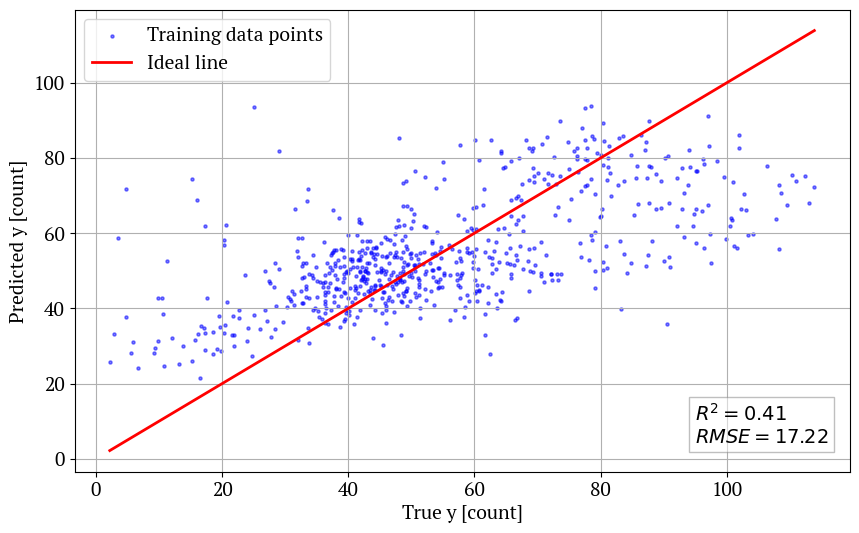

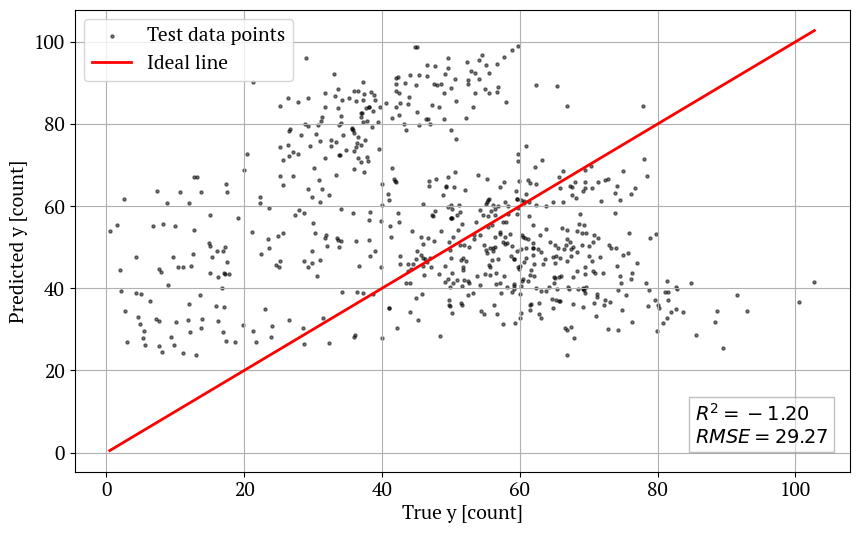

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Sample data with 6 features
#X = np.array(X_in)
#y = np.array(y_in)

# Shuffle the data
#np.random.seed(42)  # For reproducibility
#indices = np.arange(len(y))
#np.random.shuffle(indices)

#X = X[indices]
#y = y[indices]

# Define the size of the test set
#test_size = int(len(X)/4) # Number of initial data points to be used as the test set
# Split the data into training and test sets
#X_train = X[test_size:]
#y_train = y[test_size:]
#X_test = X[:test_size]
#y_test = y[:test_size]

# Create a linear regression model
model = LinearRegression()
# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the y values for training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate the model on the training and test sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

#print(f"Train set RMSE: {train_rmse}")
#print(f"Test set RMSE: {test_rmse}")
#print(f"Train set R-squared: {train_r2}")
#print(f"Test set R-squared: {test_r2}")

# Print the coefficients
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")

# Plot training results
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred, s=5, alpha=0.5, color='blue', label='Training data points')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linewidth=2, label='Ideal line')
plt.xlabel('True y [count]', fontdict={'fontname': 'PT Serif', 'fontsize': 14})
plt.ylabel('Predicted y [count]', fontdict={'fontname': 'PT Serif', 'fontsize': 14})
plt.xticks(fontname='PT Serif', fontsize=14)
plt.yticks(fontname='PT Serif', fontsize=14)
plt.legend(prop={'family': 'PT Serif', 'size': 14})
plt.grid(True)
    # Add text box for RMSE and R-squared
textstr = r'$R^2 = %.2f$' '\n' r'$RMSE = %.2f$' % (train_r2, train_rmse)
plt.text(0.80, 0.15, textstr, transform=plt.gca().transAxes, fontsize=14, 
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='gray'))
plt.savefig('/Users/andres/Documents/yield_data/reg_train.pdf', dpi=300)
plt.show()

# Plot test results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, s=5, alpha=0.5, color='black', label='Test data points')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2, label='Ideal line')
plt.xlabel('True y [count]', fontdict={'fontname': 'PT Serif', 'fontsize': 14})
plt.ylabel('Predicted y [count]', fontdict={'fontname': 'PT Serif', 'fontsize': 14})
#plt.title('Test Data: True vs Predicted y values')
plt.xticks(fontname='PT Serif', fontsize=14)
plt.yticks(fontname='PT Serif', fontsize=14)
plt.legend(prop={'family': 'PT Serif', 'size': 14})
plt.grid(True)
textstr = r'$R^2 = %.2f$' '\n' r'$RMSE = %.2f$' % (test_r2, test_rmse)
plt.text(0.80, 0.15, textstr, transform=plt.gca().transAxes, fontsize=14, 
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='gray'))
plt.savefig('/Users/andres/Documents/yield_data/reg_test.pdf', dpi=300)
plt.show()